In [1]:
import io
import urllib.parse
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn.svm import LinearSVC

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Reading the dataset and choosing the features

Here we first <strong><em>convert our dataset to a pandas dataframe</em></strong> where each of column will represent http header fields apart from the method fields. We will be using all of the available to train a classifier in a supervised way.

In [2]:
# data
normal_traffic1 = 'data/normalTrafficTraining.txt'
normal_traffic2 = 'data/normalTrafficTest.txt'
anomalous_traffic = 'data/anomalousTrafficTest.txt'

In [3]:
# helper function to convert ["key:value"] to {"key":"value"}
def list_to_dict(list_of_dicts):
    return dict(map(lambda s : s.split(':'), list_of_dicts))

In [4]:
# This function serves to convert the dataset to a pandas dataframe where each
# column corresponds to http header fields

def get_features(file_in):
    fin = open(file_in)
    lines = fin.readlines()
    features = []
    data = []
    full_dict = {} # final dictionary that will be converted to DataFrame
    i = 0
    while (i < len(lines)):
        line = lines[i].strip()
        if (line.startswith("GET") or line.startswith("POST") or line.startswith("PUT")):
            if len(features) == 0:
                method = line.split(' ')[0]
            if len(features) != 0:
                features.append("Method: " + method)
                dict_features = list_to_dict(features)
                data.append(dict_features)
                features = []
                method = line.split(' ')[0]
        elif line.startswith("Content-Length") :
            features.append(line)
            i += 2
        elif line.startswith("Host"):
            host = line.split(':')[2]
            features.append("Host: " + host)
        elif line:
            features.append(line)
        i += 1
    
    # including the last line
    features.append("Method: " + method)
    dict_features = list_to_dict(features)
    data.append(dict_features)
    # converting the list of dictionaries to a final dictionary (that will be converted to DataFrame)
    i = 0
    for entry in data:
        # add a dictionary entry to the final dictionary
        if "Content-Length" in entry: # POST and PUT cases
            full_dict[i] = {"method": entry['Method'], "user_agent": entry['User-Agent'], "pragma": entry['Pragma'], "cookie": entry['Cookie'],
                            "cache_control": entry['Cache-control'], "accept": entry['Accept'], "accept_encoding": entry['Accept-Encoding'], 
                            "accept_char": entry['Accept-Charset'], "accept_lang": entry['Accept-Language'], "host": entry['Host'], 
                            "connection": entry["Connection"], "content_type": entry['Content-Type'], "content_len": entry['Content-Length']}
        else: # GET case
            full_dict[i] = {"method": entry['Method'], "user_agent": entry['User-Agent'], "pragma": entry['Pragma'], "cookie": entry['Cookie'],
                            "cache_control": entry['Cache-control'], "accept": entry['Accept'], "accept_encoding": entry['Accept-Encoding'], 
                            "accept_char": entry['Accept-Charset'], "accept_lang": entry['Accept-Language'], "host": entry['Host'], 
                            "connection": entry["Connection"], "content_type": 'NULL', "content_len": 'NULL'}

        i = i + 1
    
    #converting to Dataframe
    df_features = pd.DataFrame.from_dict(full_dict, orient="index")
    fin.close()
    return df_features

In [5]:
df_normal = get_features(normal_traffic1)
df_normal = pd.concat([df_normal, get_features(normal_traffic2)])
df_normal.head()

,method,user_agent,pragma,cookie,cache_control,accept,accept_encoding,accept_char,accept_lang,host,connection,content_type,content_len
0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
1,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
2,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=933185092E0B668B90676E0A2B0767AF,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,68
3,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
4,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,application/x-www-form-urlencoded,63


In [6]:
df_normal.describe()

,method,user_agent,pragma,cookie,cache_control,accept,accept_encoding,accept_char,accept_lang,host,connection,content_type,content_len
count,72000,72000,72000,72000,72000,72000,72000,72000,72000,72000,72000,72000,72000
unique,2,1,1,72000,1,1,1,1,1,1,1,2,121
top,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=FBF3D49BA79721303944911602C0967E,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
freq,56000,72000,72000,1,72000,72000,72000,72000,72000,72000,72000,56000,56000


In [7]:
df_anomalous = get_features(anomalous_traffic)
df_anomalous.describe()

,method,user_agent,pragma,cookie,cache_control,accept,accept_encoding,accept_char,accept_lang,host,connection,content_type,content_len
count,25065,25065,25065,25065,25065,25065,25065,25065,25065,25065,25065,25065,25065
unique,3,1,1,25065,1,2,1,1,1,2,1,2,383
top,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux...,no-cache,JSESSIONID=151A465ECC5D86C46EC6C99ED1534DC0,no-cache,"text/xml,application/xml,application/xhtml+xm...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,8080,close,NULL,NULL
freq,15088,25065,25065,1,25065,24668,25065,25065,25065,24668,25065,15088,15088


In [8]:
pd.crosstab(df_normal.content_type, df_normal.method) # NULL if GET method

method,GET,POST
content_type,,
application/x-www-form-urlencoded,0,16000
NULL,56000,0


In [9]:
pd.crosstab(df_anomalous.accept, df_anomalous.method) # depends only on PUT method

method,GET,POST,PUT
accept,,,
"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5",15088,9580,0
"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5",0,0,397


In [10]:
pd.crosstab(df_anomalous.host, df_anomalous.method) # depends only on PUT method

method,GET,POST,PUT
host,,,
8080,15088,9580,0
9090,0,0,397


We see that all columns except 'cookie', 'content_type', 'content_length', 'host', 'accept' have only one unique value. Therefore, they <strong><em>do not contribute any information for classification</em></strong>. 

The column 'content_type' has two possible values, because of the absence of content in the GET method. So it also does not contribute information about the anomaly. 

The columns 'accept' and 'host' have two possible values and only depend whether the method is PUT or not. So it also does not contribute information about the anomaly. 

The 'cookie' column has unique sessionID for each rows, and it is not usable in our classification. 

The 'content_len' is similar to 'content_type' and it is present only for the POST and PUT methods. Its information is contained on the message body.

<strong><em>From this we can deduce that we can classify only using the method field and the messagy body.</em></strong>

## Getting the method field and the message body

Here we extract the method fields from the dataset. For PUT and POST methods we append the message body to the method field.

In [11]:
def get_method_msgbody(file_in):
    fin = open(file_in)
    lines = fin.readlines()
    method_msgbody = []
    for i in range(len(lines)):
        line = lines[i].strip()
        
        if line.startswith("GET"):
            url = line.split(" ")[1]
            url = urllib.parse.unquote(urllib.parse.unquote(url)).replace('\n','') #decoding the %xx escapes
            method_msgbody.append("GET " + url)
        elif (line.startswith("POST") or line.startswith("PUT")):
            method = line.split(" ")[0]
            url = line.split(" ")[1]
            
            #merging the query to the method field
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            url = urllib.parse.unquote(urllib.parse.unquote(url)).replace('\n','')
            method_msgbody.append(method + " " + url)
    fin.close()
    return method_msgbody

In [12]:
#generating a dataframe for normal requests (we merge train and test data)
normal_requests1 = get_method_msgbody(normal_traffic1)
normal_requests2 = get_method_msgbody(normal_traffic2)
df_normal_requests = pd.concat([pd.DataFrame(normal_requests1), pd.DataFrame(normal_requests2)])
df_normal_requests.rename(columns = {0: 'requests'}, inplace=True)
df_normal_requests.drop_duplicates(inplace=True) #get rid of all the duplicates
df_normal_requests["labels"] = 0

df_normal_requests.head()

,requests,labels
0,GET http://localhost:8080/tienda1/index.jsp,0
1,GET http://localhost:8080/tienda1/publico/anad...,0
2,POST http://localhost:8080/tienda1/publico/ana...,0
3,GET http://localhost:8080/tienda1/publico/aute...,0
4,POST http://localhost:8080/tienda1/publico/aut...,0


In [13]:
#generating a dataframe for anomalous requests
anomalous_requests = get_method_msgbody(anomalous_traffic)
df_anomalous_requests = pd.DataFrame(anomalous_requests)
df_anomalous_requests.rename(columns = {0: 'requests'}, inplace=True)
df_anomalous_requests.drop_duplicates(inplace=True)
df_anomalous_requests["labels"] = 1
df_anomalous_requests.head()

,requests,labels
0,GET http://localhost:8080/tienda1/publico/anad...,1
1,POST http://localhost:8080/tienda1/publico/ana...,1
2,GET http://localhost:8080/tienda1/publico/anad...,1
3,POST http://localhost:8080/tienda1/publico/ana...,1
4,GET http://localhost:8080/asf-logo-wide.gif~,1


In [14]:
#Because of the removal of cookie IDs, a lot of requests are not unique
print("After removing the duplicates: ")
print("Number of normal requests: ", df_normal_requests.shape[0])
print("Number of anomalous requests: ", df_anomalous_requests.shape[0])

After removing the duplicates: 
Number of normal requests:  18640
Number of anomalous requests:  15874


In [15]:
# full dataframe containing both both traffics

df_full = pd.concat([df_normal_requests, df_anomalous_requests], ignore_index=True, sort='False') 

## Bag-of-Words model with TFidfVectorizer

We cannot directly work directly with the long texts for classification. A more useful method is to <strong><em>convert the text to sparse vectors</em></strong>, where we encode information according to a vocabulary.

TFidfVectorizer will build the vocabulary of words from our dataset. However, we will give the tokenization method ourselves, since the built-in tokenizer is not suitable for our http request texts

In [16]:
# custom tokenizer
def tokenize(f):
    #splitting to parts by removing special symbols
    tokens = list(filter(None, re.split(":|=|>|<|\(|\)|\.|\?|@|\+|&|/|-|'|\[|\]| |,|\^|{|}|;|~|!|\*|\"", f)))
    
    #removing common names
    tokens.remove("http")
    tokens.remove("localhost")
    
    #removing numbers
    tokens = [x for x in tokens if not x[0].isdigit()]
    return tokens

In [17]:
requests = df_full["requests"]
labels = df_full["labels"].values

In [18]:
# TFidf
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(requests)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Below we can see the vocabulary that was build by Tfidf. These features will be used by classifiers. 
vectorizer.vocabulary_

{'get': 13493,
 'tienda1': 30329,
 'index': 15935,
 'jsp': 16834,
 'publico': 25193,
 'anadir': 1767,
 'id': 15685,
 'nombre': 22382,
 'vino': 32341,
 'rioja': 26530,
 'precio': 24965,
 'cantidad': 6022,
 'b1': 3088,
 'a�adir': 3070,
 'al': 897,
 'carrito': 6306,
 'post': 24869,
 'autenticar': 2881,
 'modo': 21012,
 'entrar': 11075,
 'login': 18799,
 'choong': 7240,
 'pwd': 25333,
 'd1se3ci�n': 8813,
 'remember': 26153,
 'off': 22711,
 'caracteristicas': 6111,
 'errormsg': 11241,
 'credenciales': 8430,
 'incorrectas': 15907,
 'miembros': 20724,
 'pagar': 23411,
 'insertar': 16054,
 'pasar': 23733,
 'por': 24797,
 'caja': 5674,
 'productos': 25087,
 'registro': 26072,
 'cen': 6798,
 'password': 23769,
 'nurit': 22537,
 'apellidos': 2083,
 'ferrandez': 12158,
 'caba�as': 5582,
 'email': 10761,
 'tarpey': 29870,
 'bwds': 5378,
 'ne': 22029,
 'dni': 9869,
 'direccion': 9809,
 'calle': 5763,
 'clavel': 7520,
 'b': 3081,
 'ciudad': 7454,
 'tronch�n': 30946,
 'cp': 8390,
 'provincia': 25138,


### Visualising the Tfidf vocabulary

We can see from the plots below, how the Tfidf scores differ for different inputs

In [20]:
def top_tfidf_feats(Xtr, features, row_id, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    row = np.squeeze(Xtr[row_id].toarray())
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [21]:
def plot_tfidf(df):
    ''' Plot the top features. '''
    x = np.arange(len(df))
    plt.xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    plt.barh(x, df.tfidf, align='center', color='#3F5D7D')
    plt.yticks(x, df.feature)
    plt.ylim([-1, x[-1]+1])
    plt.show()

Label:  0
Top TFidf scores for a normal request


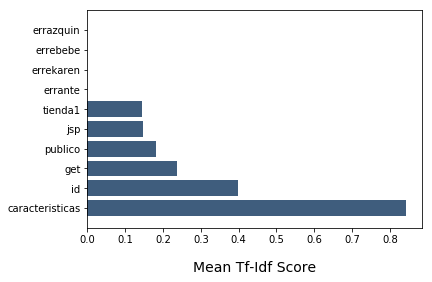

In [22]:
#visualize a sample normal request
norm_id = 5
top_feats = top_tfidf_feats(X, vectorizer.get_feature_names(), row_id = norm_id)
print("Label: ", y[norm_id])
print("Top TFidf scores for a normal request")
plot_tfidf(top_feats)

Label:  1
Top TFidf scores for an anomalous request


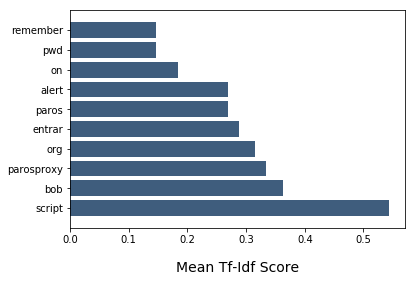

In [23]:
#visualize a sample anomalous request
anom_id = 18645
top_feats = top_tfidf_feats(X, vectorizer.get_feature_names(), row_id = anom_id)
print("Label: ", y[anom_id])
print("Top TFidf scores for an anomalous request")
plot_tfidf(top_feats)

Here we can see some features of an anomalous request. It contains words such as <strong><em>"alert", "script"</em></strong> that may be related to some type of http attacks. Our classifiers will benefit from these kinds of important features.

## Classification

Here we use Linear SVM classifier, first we tune the penalty parameter "C", using cross-validation

In [24]:
# cross-validation
Cs = np.logspace(-5, 1, 6) # vector containing values of C
linear_svm = LinearSVC(random_state=42)

val_train, val_test = validation_curve(linear_svm, X_train, y_train,
                                       param_name='C', param_range=Cs, cv=5,
                                       scoring='roc_auc')

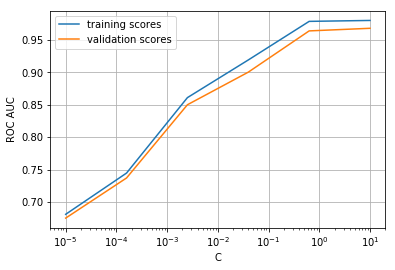

In [25]:
plt.plot(Cs, val_train.mean(1), label='training scores')
plt.plot(Cs, val_test.mean(1), label='validation scores')
plt.xlabel("C"); plt.ylabel('ROC AUC')
plt.xscale("log")
plt.legend()
plt.grid(True);

In [26]:
#Linear SVM
linear_svm=LinearSVC(C=10, random_state=42)
linear_svm.fit(X_train, y_train)

y_pred = linear_svm.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Linear SVM:")
print ("ROC-AUC score :",roc_auc)
print ("Confusion Matrix: ")
print (conf_matrix)

Linear SVM:
ROC-AUC score : 0.9333679153693484
Confusion Matrix: 
[[3652   30]
 [ 403 2818]]


## Conclusion and Remarks

In this project, the CSIC 2010 HTTP dataset was analyzed to train a classifier for anomalous traffic detection. The HTTP requests on the were parsed and important features were selected using the TFidf vectorizer.

* The performance of the classifier can be improved, by using a more powerful tokenizer function
* More detailed feature selection can be implemented (remove some fields such as passwords)

With more thorough feature selection and training powerful classifiers, we can get more insight on the patterns of the anomalous attacks

### References
1) https://github.com/Monkey-D-Groot/Machine-Learning-on-CSIC-2010 (took some ideas about parsing)

2) https://buhrmann.github.io/tfidf-analysis.html (plot function for TFidf)